In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [ ]:
# --- 1. MEMBACA DAN MEMPERSIAPKAN DATA ---
print("1. Membaca file data...")
try:
    # Ganti nama file jika berbeda
    df = pd.read_csv("dataset/data_cuaca_augmented.csv") 
except FileNotFoundError:
    print("Error: File 'data_cuaca_historis_bandung.csv' tidak ditemukan.")
    exit()

1. Membaca file data...


<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
C:\Users\bowow\AppData\Local\Temp\ipykernel_27640\3059200174.py:5: SyntaxWarning: invalid escape sequence '\d'
  df = pd.read_csv("dataset\data_cuaca_augmented.csv")


In [3]:
# Mengubah 'timestamp' menjadi tipe data datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

print(f"Data berhasil dibaca. Jumlah baris: {len(df)}")
print("Contoh data:")
print(df.head())

Data berhasil dibaca. Jumlah baris: 21448
Contoh data:
                   timestamp   suhu  kelembaban  kecepatan_angin  arah_angin  \
0 2025-08-08 20:01:36.758732  27.36        92.0             0.36       294.0   
1 2025-08-08 20:02:50.420451  27.36        92.0             0.36       294.0   
2 2025-08-08 20:12:50.561777  26.75        88.0             0.16       325.0   
3 2025-08-08 20:14:24.682701  26.75        88.0             0.16       325.0   
4 2025-08-08 20:16:24.809625  26.75        88.0             0.16       325.0   

   tekanan_udara  intensitas_hujan  
0         1014.0               0.0  
1         1014.0               0.0  
2         1014.0               0.0  
3         1014.0               0.0  
4         1014.0               0.0  


In [4]:
def tentukan_kelas_prediksi(row, langkah_prediksi):
    # Cek apakah akan hujan dalam 'langkah_prediksi' ke depan
    akan_hujan = row['intensitas_hujan_mendatang'] > 0
    
    if not akan_hujan:
        return 0 # Kelas 0: Tidak Hujan
    
    # Jika akan hujan, tentukan arahnya dari 'arah_angin' saat ini
    arah_angin = row['arah_angin']
    
    if 337.5 <= arah_angin < 360 or 0 <= arah_angin < 22.5:
        return 1 # Utara
    elif 22.5 <= arah_angin < 67.5:
        return 2 # Timur Laut
    elif 67.5 <= arah_angin < 112.5:
        return 3 # Timur
    elif 112.5 <= arah_angin < 157.5:
        return 4 # Tenggara
    elif 157.5 <= arah_angin < 202.5:
        return 5 # Selatan
    elif 202.5 <= arah_angin < 247.5:
        return 6 # Barat Daya
    elif 247.5 <= arah_angin < 292.5:
        return 7 # Barat
    else: # 292.5 <= arah_angin < 337.5
        return 8 # Barat Laut

# --- Di dalam skrip latih_model.py Anda ---
# Ganti blok Feature Engineering Anda dengan ini:

# ... (setelah membaca df)
langkah_prediksi = 15
df['intensitas_hujan_mendatang'] = df['intensitas_hujan'].shift(-langkah_prediksi).rolling(window=langkah_prediksi).max()
df.dropna(inplace=True)

# Buat target multi-kelas baru
df['target_prediksi'] = df.apply(lambda row: tentukan_kelas_prediksi(row, langkah_prediksi), axis=1)

# Hapus kolom bantuan
df.drop(columns=['intensitas_hujan_mendatang'], inplace=True)

# Target (y) sekarang adalah kolom baru ini
y = df['target_prediksi']

In [5]:
# --- 3. MEMISAHKAN FITUR (X) DAN TARGET (y) ---
print("\n3. Memisahkan fitur (X) dan target (y)...")

# Fitur (input) adalah kondisi cuaca saat ini.
fitur = ['suhu', 'kelembaban', 'kecepatan_angin', 'arah_angin', 'tekanan_udara', 'intensitas_hujan']
X = df[fitur]

# Target (output) adalah apa yang ingin kita prediksi.
y = df['target_prediksi']


3. Memisahkan fitur (X) dan target (y)...


In [6]:
# Tambahkan baris ini untuk melihat jumlah data per kelas
print("Mengecek distribusi kelas pada variabel y:")
print(y.value_counts())


Mengecek distribusi kelas pada variabel y:
target_prediksi
0    16522
1     1882
4      995
2      812
3      502
8      466
6      115
5      110
7       15
Name: count, dtype: int64


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
# --- 5. MELATIH MODEL MACHINE LEARNING ---
print("\n5. Melatih model XGBClassifier...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# class_weight='balanced' -> Memberi perhatian lebih pada kelas minoritas (hujan), sangat penting!
model = SVC(kernel='rbf', random_state=42, class_weight='balanced', probability=True)
model.fit(X_train_scaled, y_train)

print("Model berhasil dilatih!")


5. Melatih model XGBClassifier...
Model berhasil dilatih!



6. Mengevaluasi performa model pada data testing...

> Akurasi Model: 61.83%

> Laporan Klasifikasi:
                       precision    recall  f1-score   support

          Tidak Hujan       0.99      0.52      0.69      3305
     Hujan dari Utara       0.55      0.89      0.68       377
Hujan dari Timur Laut       0.35      0.99      0.52       162
     Hujan dari Timur       0.28      0.98      0.43       100
  Hujan dari Tenggara       0.25      0.92      0.39       199
   Hujan dari Selatan       0.23      1.00      0.38        22
Hujan dari Barat Daya       0.55      1.00      0.71        23
     Hujan dari Barat       1.00      1.00      1.00         3
Hujan dari Barat Laut       0.42      1.00      0.59        93

             accuracy                           0.62      4284
            macro avg       0.51      0.92      0.60      4284
         weighted avg       0.86      0.62      0.66      4284


> Confusion Matrix:


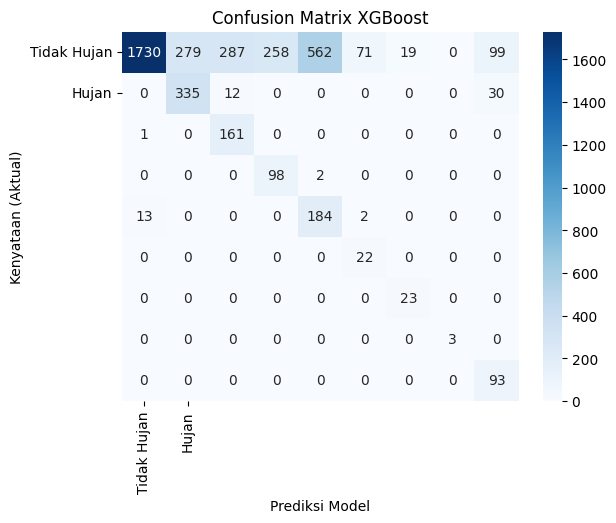

In [9]:
# --- 6. MENGEVALUASI PERFORMA MODEL ---
print("\n6. Mengevaluasi performa model pada data testing...")

# Lakukan prediksi pada data yang belum pernah dilihat model (data testing)
# y_pred = model.predict(X_test)
y_pred = model.predict(X_test_scaled)

# A. Akurasi
akurasi = accuracy_score(y_test, y_pred)
print(f"\n> Akurasi Model: {akurasi:.2%}")
# Definisikan daftar nama yang sesuai dengan 9 kelas Anda
nama_kelas = [
    'Tidak Hujan',           # Kelas 0
    'Hujan dari Utara',      # Kelas 1
    'Hujan dari Timur Laut', # Kelas 2
    'Hujan dari Timur',      # Kelas 3
    'Hujan dari Tenggara',   # Kelas 4
    'Hujan dari Selatan',    # Kelas 5
    'Hujan dari Barat Daya', # Kelas 6
    'Hujan dari Barat',      # Kelas 7
    'Hujan dari Barat Laut'  # Kelas 8
]
# nama_kelas = [
#     'Tidak Hujan',           # Kelas 0
#     'Hujan dari Utara',      # Kelas 1
#     'Hujan dari Timur Laut', # Kelas 2
#     'Hujan dari Timur',      # Kelas 3
#     'Hujan dari Tenggara',   # Kelas 4
#     'Hujan dari Selatan',    # Kelas 5
#     'Hujan dari Barat Daya', # Kelas 6
#     'Hujan dari Barat Laut'  # Kelas 8
# ]

# B. Laporan Klasifikasi
print("\n> Laporan Klasifikasi:")
# Laporan ini memberikan info Precision, Recall, dan F1-Score
# 'Recall' untuk kelas 'Hujan' adalah metrik paling penting di sini.
#print(classification_report(y_test, y_pred, target_names=['Tidak Hujan', 'Hujan']))
# Kode Anda yang menyebabkan error
# print(classification_report(y_test, y_pred, target_names=['Tidak Hujan', 'Hujan']))

# Kode yang benar
print(classification_report(y_test, y_pred, target_names=nama_kelas))

# C. Confusion Matrix (Opsional, untuk visualisasi)
print("\n> Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Tidak Hujan', 'Hujan'], yticklabels=['Tidak Hujan', 'Hujan'])
plt.xlabel('Prediksi Model')
plt.ylabel('Kenyataan (Aktual)')
plt.title('Confusion Matrix XGBoost')
plt.show() # Tampilkan plot

In [10]:
# ... (kode evaluasi model Anda sebelumnya) ...

# --- 7. SIMPAN MODEL KE FILE ---
import joblib

print("\n7. Menyimpan model ke file...")
nama_file_model = 'model_prediksi_hujan_darimana_SVM.joblib'
joblib.dump(model, nama_file_model)
print(f"Model telah disimpan ke file: {nama_file_model}")


7. Menyimpan model ke file...
Model telah disimpan ke file: model_prediksi_hujan_darimana_SVM.joblib
